In [1]:
%matplotlib inline

import os
import sys

PACKAGE_PARENT = '..'
sys.path.append(PACKAGE_PARENT)

import json
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

from gaminet import GAMINetClassifier
from gaminet import GAMINetRegressor
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

In [2]:
def load_fico(path="./", missing_strategy="drop"):
    data = pd.read_csv(path + "/fico/heloc_dataset_v1.csv")
    meta_info = json.load(open(path + "/fico/data_types.json"))
    meta_info.pop("RiskPerformance")

    ## remove samples with all the values == -9
    rem_sample_idx = np.where(np.sum(data.values[:, 1:].astype(float) == -9, 1) == 23)[0]
    keep_sample_idx = np.where(np.sum(data.values[:, 1:].astype(float) == -9, 1) < 23)[0]
    data_rem9 = data.iloc[keep_sample_idx]

    ## dummy for -7, -8, -9
    sample_size = data_rem9.shape[0]
    dummy_data = pd.DataFrame(index = data_rem9.index)
    for i in np.where(np.sum(data_rem9 == -9, 0).values > 0)[0]:
        temp = np.zeros(sample_size)
        temp[np.where(data_rem9.iloc[:, i].values == -9)[0]] = 1
        dummy_data[data_rem9.columns[i] + "_D-9"] = temp
        meta_info.update({data_rem9.columns[i] + "_D-9":{"type": "categorical"}})

    for i in np.where(np.sum(data_rem9 == -8, 0).values > 0)[0]:
        temp = np.zeros(sample_size)
        temp[np.where(data_rem9.iloc[:, i].values == -8)[0]] = 1
        dummy_data[data_rem9.columns[i] + "_D-8"] = temp
        meta_info.update({data_rem9.columns[i] + "_D-8":{"type": "categorical"}})

    for i in np.where(np.sum(data_rem9 == -7, 0).values > 0)[0]:
        temp = np.zeros(sample_size)
        temp[np.where(data_rem9.iloc[:, i].values == -7)[0]] = 1
        dummy_data[data_rem9.columns[i] + "_D-7"] = temp
        meta_info.update({data_rem9.columns[i] + "_D-7":{"type": "categorical"}})

    meta_info.update({"RiskPerformance":{"type": "target"}})
    final_data = pd.concat([data_rem9.replace(-9, 0).replace(-8, 0).replace(-7, 0), dummy_data], 1)
    x, y = final_data.iloc[:,1:].values, final_data.iloc[:,[0]].values
    return x, y, "Classification", meta_info

def load_classification_data(name):
    data_path = '.'
    func_dict = {'fico':load_fico}
    def wrapper(random_state):
        function_name_ = func_dict[name]
        x, y, task_type, meta_info = function_name_(data_path, missing_strategy="impute")
        xx = np.zeros((x.shape[0], x.shape[1]), dtype=np.float32)
        for i, (key, item) in enumerate(meta_info.items()):
            if item['type'] == 'target':
                enc = OrdinalEncoder()
                enc.fit(y)
                y = enc.transform(y)
                meta_info[key]['values'] = enc.categories_[0].tolist()
            elif item['type'] == 'categorical':
                enc = OrdinalEncoder()
                xx[:,[i]] = enc.fit_transform(x[:,[i]])
                meta_info[key]['values'] = []
                for item in enc.categories_[0].tolist():
                    try:
                        if item == int(item):
                            meta_info[key]['values'].append(str(int(item)))
                        else:
                            meta_info[key]['values'].append(str(item))
                    except ValueError:
                        meta_info[key]['values'].append(str(item))
            else:
                sx = MinMaxScaler((0, 1))
                xx[:,[i]] = sx.fit_transform(x[:,[i]])
                meta_info[key]['scaler'] = sx
        train_x, test_x, train_y, test_y = train_test_split(xx.astype(np.float32), y, stratify=y,
                                                            test_size=0.2, random_state=random_state)
        return train_x, test_x, train_y, test_y, task_type, meta_info
    return wrapper

In [3]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def auc(label, pred, scaler=None):
    return roc_auc_score(label, pred)

get_metric = metric_wrapper(auc, None)

In [4]:
random_state = 0
data_loader = load_classification_data("fico")
train_x, test_x, train_y, test_y, task_type, meta_info = data_loader(random_state)

/tmp/ipykernel_1679716/755819285.py:33: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  final_data = pd.concat([data_rem9.replace(-9, 0).replace(-8, 0).replace(-7, 0), dummy_data], 1)


In [5]:
meta_info.keys()

dict_keys(['ExternalRiskEstimate', 'MSinceOldestTradeOpen', 'MSinceMostRecentTradeOpen', 'AverageMInFile', 'NumSatisfactoryTrades', 'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec', 'PercentTradesNeverDelq', 'MSinceMostRecentDelq', 'MaxDelq2PublicRecLast12M', 'MaxDelqEver', 'NumTotalTrades', 'NumTradesOpeninLast12M', 'PercentInstallTrades', 'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 'NumInqLast6Mexcl7days', 'NetFractionRevolvingBurden', 'NetFractionInstallBurden', 'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance', 'NumBank2NatlTradesWHighUtilization', 'PercentTradesWBalance', 'ExternalRiskEstimate_D-9', 'MSinceOldestTradeOpen_D-8', 'MSinceMostRecentDelq_D-8', 'MSinceMostRecentInqexcl7days_D-8', 'NetFractionRevolvingBurden_D-8', 'NetFractionInstallBurden_D-8', 'NumRevolvingTradesWBalance_D-8', 'NumInstallTradesWBalance_D-8', 'NumBank2NatlTradesWHighUtilization_D-8', 'PercentTradesWBalance_D-8', 'MSinceMostRecentDelq_D-7', 'MSinceMostRecentInqexcl7days_D-7', 'Risk

In [6]:
model = GAMINetClassifier(interact_num=10,
                         subnet_size_main_effect=[100] * 1,
                         subnet_size_interaction=[200] * 1, 
                         max_epochs=[1000, 1000, 1000],
                         learning_rates=[0.001, 0.001, 0.001],
                         early_stop_thres=["auto", "auto", "auto"],
                         batch_size=1000,
                         warm_start=True,
                         reg_clarity=0.1,
                         reg_mono=0.1,
                         mono_increasing_list=[0, 1, 2, 3, 4, 7, 8, 9, 10, 14],
                         mono_decreasing_list=[5, 6, 12, 15, 16, 17, 18, 21],
                         verbose=True,
                         random_state=random_state)
model.fit(train_x, train_y)

####################Stage 1: Main Effect Training####################
###############Run Warm Initialization for Main Effect###############


Epoch:    1, train loss: 0.53836, validation loss: 0.52712: 100%|██████████| 7/7 [00:00<00:00, 32.84it/s]                          
Epoch:    2, train loss: 0.53447, validation loss: 0.53715: 100%|██████████| 7/7 [00:00<00:00, 34.54it/s]                          
Epoch:    3, train loss: 0.53384, validation loss: 0.53065: 100%|██████████| 7/7 [00:00<00:00, 34.26it/s]                          
Epoch:    4, train loss: 0.53076, validation loss: 0.53103: 100%|██████████| 7/7 [00:00<00:00, 34.89it/s]                          
Epoch:    5, train loss: 0.52941, validation loss: 0.52989: 100%|██████████| 7/7 [00:00<00:00, 35.91it/s]                          
Epoch:    6, train loss: 0.52797, validation loss: 0.53155: 100%|██████████| 7/7 [00:00<00:00, 34.56it/s]                          
Epoch:    7, train loss: 0.52834, validation loss: 0.53286: 100%|██████████| 7/7 [00:00<00:00, 34.11it/s]                          
Epoch:    8, train loss: 0.52955, validation loss: 0.53545: 100%|██████████|

Main Effect Training Stop at Epoch: 56, train loss: 0.54185, validation loss: 0.55928
####################Stage 2: Interaction Training####################
###############Run Warm Initialization for Interaction###############


Epoch:    1, train loss: 0.54686, validation loss: 0.58480: 100%|██████████| 7/7 [00:00<00:00, 17.30it/s]                          
Epoch:    2, train loss: 0.57731, validation loss: 0.60853: 100%|██████████| 7/7 [00:00<00:00, 16.96it/s]                          
Epoch:    3, train loss: 0.59060, validation loss: 0.61266: 100%|██████████| 7/7 [00:00<00:00, 17.41it/s]                          
Epoch:    4, train loss: 0.58659, validation loss: 0.60146: 100%|██████████| 7/7 [00:00<00:00, 17.64it/s]                          
Epoch:    5, train loss: 0.57389, validation loss: 0.58822: 100%|██████████| 7/7 [00:00<00:00, 17.46it/s]                          
Epoch:    6, train loss: 0.56310, validation loss: 0.57873: 100%|██████████| 7/7 [00:00<00:00, 17.01it/s]                          
Epoch:    7, train loss: 0.55532, validation loss: 0.57530: 100%|██████████| 7/7 [00:00<00:00, 17.21it/s]                          
Epoch:    8, train loss: 0.55346, validation loss: 0.57528: 100%|██████████|

Interaction Training Stop at Epoch: 41, train loss: 0.56444, validation loss: 0.58624
#########################Stage 3: Fine Tuning#########################


Epoch:    1, train loss: 0.54590, validation loss: 0.54726: 100%|██████████| 7/7 [00:00<00:00, 17.10it/s]                          
Epoch:    2, train loss: 0.53589, validation loss: 0.54773: 100%|██████████| 7/7 [00:00<00:00, 16.80it/s]                          
Epoch:    3, train loss: 0.53620, validation loss: 0.54889: 100%|██████████| 7/7 [00:00<00:00, 17.40it/s]                          
Epoch:    4, train loss: 0.53701, validation loss: 0.54910: 100%|██████████| 7/7 [00:00<00:00, 15.05it/s]                          
Epoch:    5, train loss: 0.53736, validation loss: 0.54825: 100%|██████████| 7/7 [00:00<00:00, 16.97it/s]                          
Epoch:    6, train loss: 0.53638, validation loss: 0.54792: 100%|██████████| 7/7 [00:00<00:00, 17.04it/s]                          
Epoch:    7, train loss: 0.53526, validation loss: 0.54622: 100%|██████████| 7/7 [00:00<00:00, 17.22it/s]                          
Epoch:    8, train loss: 0.53482, validation loss: 0.54379: 100%|██████████|

Fine Tuning Stop at Epoch: 20, train loss: 0.53258, validation loss: 0.54675


In [7]:
pred_train = model.predict_proba(train_x)[:, 1]
pred_test = model.predict_proba(test_x)[:, 1]
gaminet_stat = np.hstack([np.round(get_metric(train_y, pred_train.ravel()),5),
                          np.round(get_metric(test_y, pred_test.ravel()),5)])
print(gaminet_stat)

[0.81153 0.80486]


In [8]:
gaminet_stat = np.hstack([np.round(np.mean(train_y.ravel() == (pred_train > 0.5).ravel()),5),
                          np.round(np.mean(test_y.ravel() == (pred_test > 0.5).ravel()),5)])
print(gaminet_stat)

[0.74291 0.73418]


In [9]:
model.certify_mono()

True

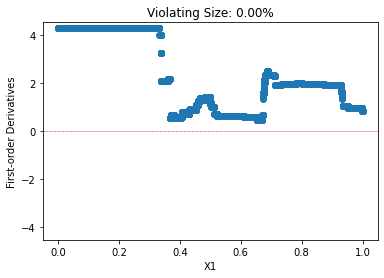

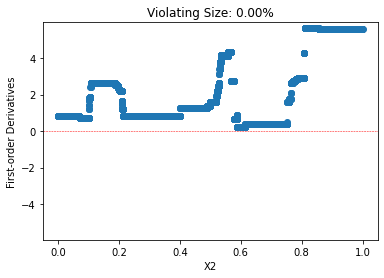

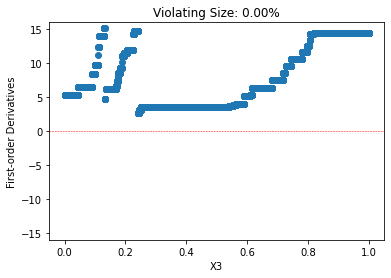

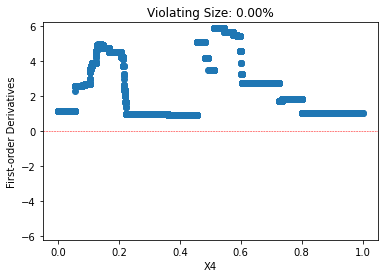

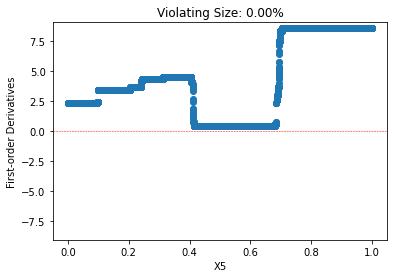

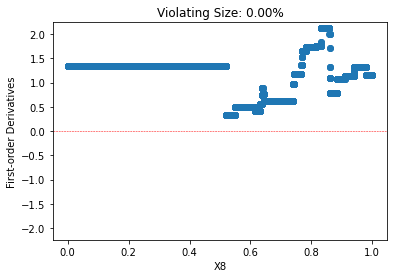

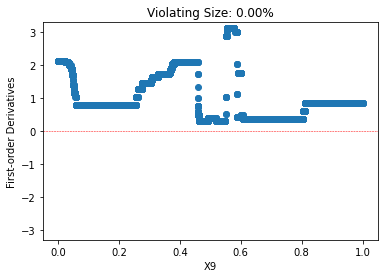

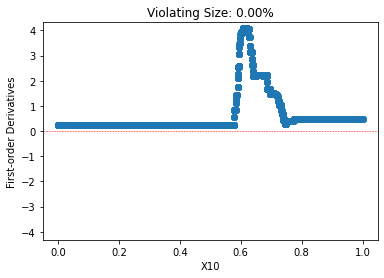

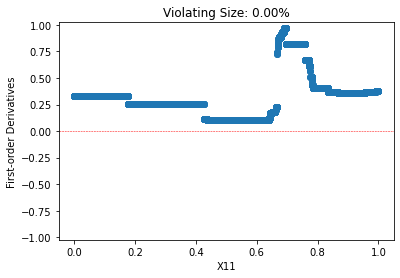

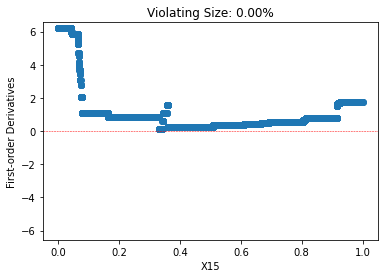

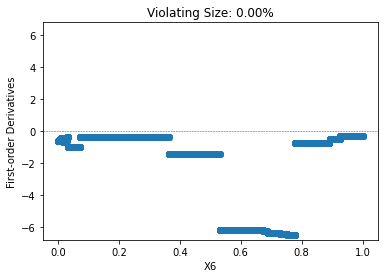

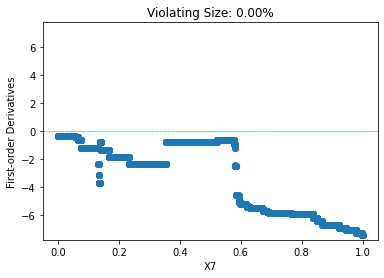

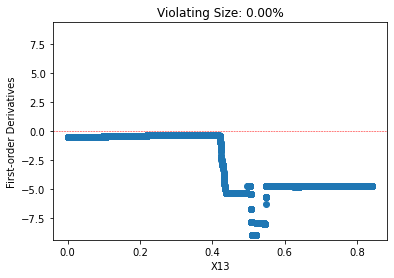

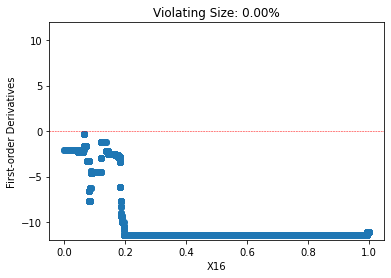

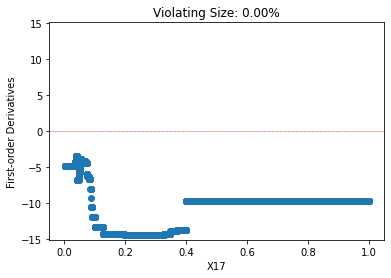

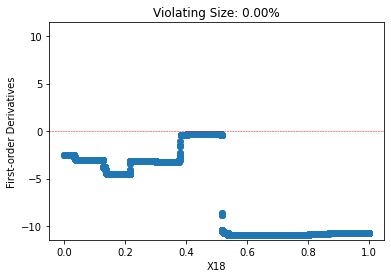

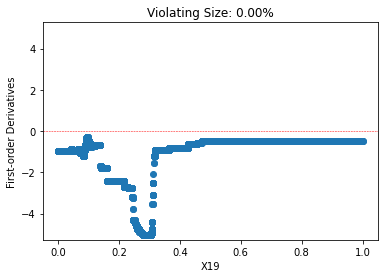

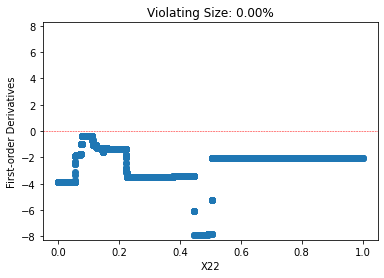

In [10]:
for i in model.mono_increasing_list + model.mono_decreasing_list:
    model.partial_derivatives(i)

Global Interpretation

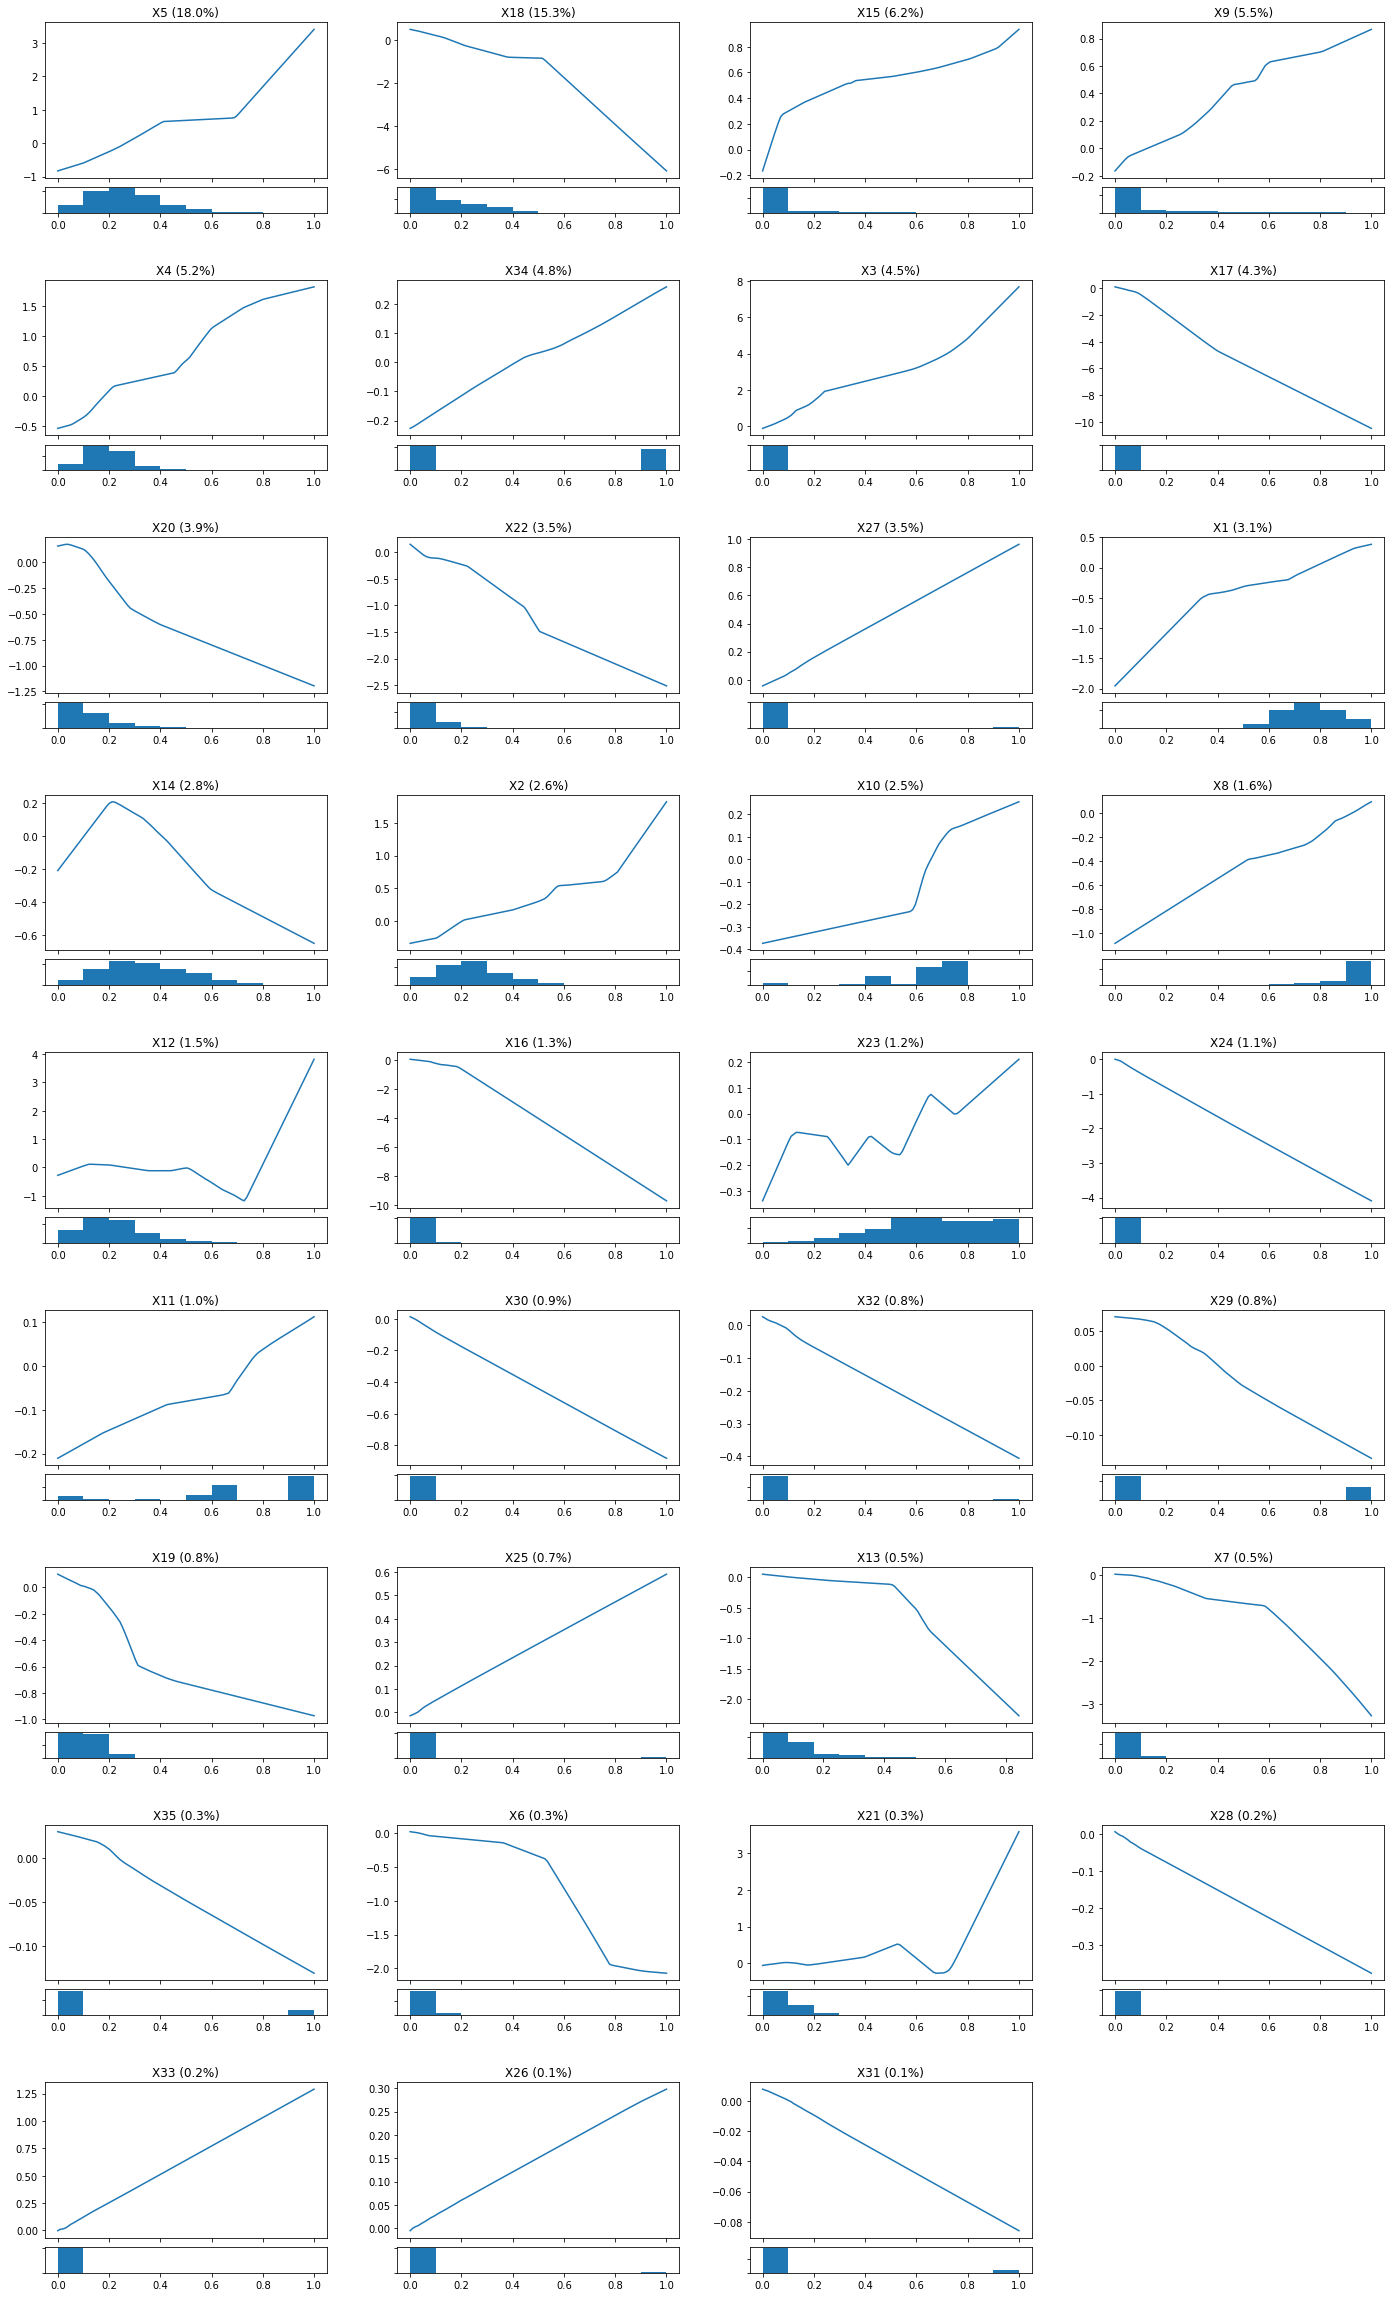

In [11]:
data_dict_global = model.global_explain(save_dict=False)
global_visualize_density(data_dict_global, main_effect_num=40, interaction_num=4, cols_per_row=4)

Feature Importance

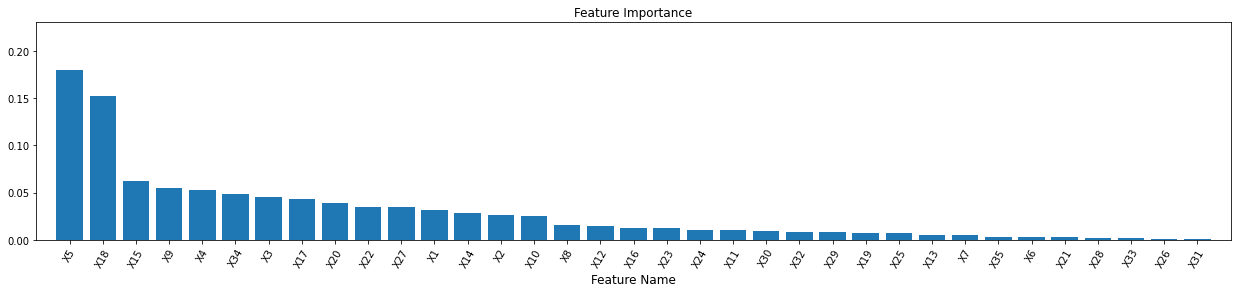

In [12]:
data_dict_global = model.global_explain(save_dict=False)
feature_importance_visualize(data_dict_global)